In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from contextlib import contextmanager
from copy import deepcopy
import math

import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange

from dev_diffusionVN_xs  import *


In [24]:

@torch.no_grad()
def sample(model, x, s, steps, eta):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            v_x, v_s = model(x, s, ts * log_snrs[i])

        # Predict the noise and the denoised image
        pred_x = x * alphas[i] - v_x * sigmas[i]
        eps_x = x * sigmas[i] + v_x * alphas[i]
        pred_s = s * alphas[i] - v_s * sigmas[i]
        eps_s = s * sigmas[i] + v_s * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred_x * alphas[i + 1] + eps_x * adjusted_sigma
            s = pred_s * alphas[i + 1] + eps_s * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma
                s += torch.randn_like(s) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred_x, pred_s

In [26]:
seed = 0

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

# 更新模型的潜在维度和隐藏层维度
latent_dim = 256

# hidden_dims = [2048,4096, 4096, 2048]  # Example of hidden dimensions
# hidden_dims = [4096,8192, 8192, 4096]  # Example of hidden dimensions
hidden_dims = [2048, 2048, 2048, 2048] 
# hidden_dims = [4096, 4096, 4096, 4096] 
max_freq = 4  # Example max frequency for Fourier features
num_bands = 4  # Number of frequency bands

# 初始化模型
# model = Diffusion().to(device)
# diffusion_model = LatentDiffusionModel(latent_dim, hidden_dims, max_freq, num_bands).to(device)
# diffusion_model = Residual_LatentDiffusionModel(latent_dim, hidden_dims, max_freq, num_bands).to(device)
# diffusion_model = Residual_LatentDiffusionModel(latent_dim, hidden_dims, max_freq, num_bands).to(device)
scalar_hidden_dims = [256,256,256,256]
diffusion_model = LatentDiffusionModel(latent_dim, hidden_dims, scalar_hidden_dims, max_freq, num_bands).to(device)
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/latent_diffusionVN.pth"
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/model.pth"
diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/vnhead_testresidual_2048*4_cos_200k/model.pth"
diffusion_ckpt = torch.load(diffusion_ckpt_path)
diffusion_model.load_state_dict(diffusion_ckpt['model'])

diffusion_model = diffusion_model.to(device)

print('Diffusion Model parameters:', sum(p.numel() for p in diffusion_model.parameters()))

scaler = torch.cuda.amp.GradScaler()
rng = torch.quasirandom.SobolEngine(1, scramble=True)
ema_decay = 0.998
steps = 1000
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.


Using device: cuda:1
Diffusion Model parameters: 51956544


In [27]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np

from dataset import get_dataset
from logger import Logger
from core.models import get_model
from core import solver_dict
from init import get_cfg, setup_seed, dev_get_cfg

# preparer configuration
cfg  =dev_get_cfg()


# set random seed
setup_seed(1)


# prepare models
ModelClass = get_model(cfg["model"]["model_name"])
model = ModelClass(cfg)
ckpt_path = "/home/ziran/se3/EFEM/weights/mugs.pt"
ckpt = torch.load(ckpt_path)


# 注意不是model.load_state_dict,
# 参见 lib_shape_prior/core/solver_v2.py, lib_shape_prior/core/models/model_base.py

model.network.load_state_dict(ckpt['model_state_dict'])
model.network.to(device)

| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-07-14:52:48 | Set GPU: 0 ...   [post_config.py:99]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-07-14:52:48 | Save configuration to local file...   [post_config.py:105]


| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-07-14:52:48 | DGCNN use Dynamic Graph (different from the input topology)   [vec_dgcnn_atten.py:50]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-07-14:52:48 | 2.016M params in encoder   [misc.py:16]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Dec-07-14:52:48 | 0.790M params in decoder   [misc.py:16]
| sim3vec-mugs | user-AS-4124GS-TNR | WARNING | Dec-07-14:52:48 | Network Components != Optimizer Config   [model_base.py:31]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Please check the configuration
--------------------------------------------------------------------------------
{'dataset': {'aug_ratio': 0.7,
             'categories': ['03797390'],
             'data_root': '../data/ShapeNetV1_SDF',
             'dataset_name': 'shapenet_new2',
             'dataset_proportion': [1.0, 1.0],
             'dataset_root': 'resource/data/XXXX',
             'dep_max_use_view': 12,
             'dep_min_use_view': 4,
             'dep_total_view': 12,
             'depth_postfix': '_dep_small',
             'field_mode': 'sdf',
             'indices': {'test_index': 'None',
                         'train_index': 'None',
                         'val_index': 'None'},
             'input_mode': 'dep',
             'n_pcl': 512,
             'n_query_eval': 10000,
             'n_query_nss': 1024,
             'n_query_uni': 1024,
             'noise_std': 0.01,
       

SIM3Recon(
  (network_dict): ModuleDict(
    (encoder): VecDGCNN_att(
      (global_conv_list): ModuleList(
        (0): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivation(
            (act_func): LeakyReLU(negative_slope=0.2)
            (lin_dir): VecLinear()
          )
          (act_func): LeakyReLU(negative_slope=0.2)
        )
        (1): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivation(
            (act_func): LeakyReLU(negative_slope=0.2)
            (lin_dir): VecLinear()
          )
          (act_func): LeakyReLU(negative_slope=0.2)
        )
        (2): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivation(
            (act_func): LeakyReLU(negative_slope=0.2)
            (lin_dir): VecLinear()
          )
          (act_func): LeakyReLU(negative_slope=0.2)
        )
        (3): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivat

In [28]:
bs=149
noise_x = torch.randn([bs, latent_dim, 3], device=device)
noise_s = torch.randn([bs, latent_dim], device=device)
fakes_x, fakes_s = sample(diffusion_model, noise_x, noise_s, steps, eta)

query_start = 0
query_end = 3
pred_so3_feat = fakes_x[query_start:query_end,:, :].to(device)
pred_inv_feat = fakes_s[query_start:query_end,:].to(device)
pred_scale = torch.ones((query_end-query_start)) + 0.2
pred_center = torch.zeros(query_end-query_start, 1, 3)

print(pred_so3_feat.shape, pred_inv_feat.shape, pred_scale.shape, pred_center.shape)
pred_so3_feat = torch.tensor(pred_so3_feat).float().to(device)
pred_inv_feat = torch.tensor(pred_inv_feat).float().to(device)
pred_scale = torch.tensor(pred_scale).float().to(device)
pred_center = torch.tensor(pred_center).float().to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([3, 256, 3]) torch.Size([3, 256]) torch.Size([3]) torch.Size([3, 1, 3])


/tmp/ipykernel_59451/3360485722.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_so3_feat = torch.tensor(pred_so3_feat).float().to(device)
/tmp/ipykernel_59451/3360485722.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_inv_feat = torch.tensor(pred_inv_feat).float().to(device)
/tmp/ipykernel_59451/3360485722.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_scale = torch.tensor(pred_scale).float().to(device)
/tmp/ipykernel_59451/3360485722.py:17: UserWarning: To copy construct from a tensor, it is recommended to 

In [29]:
torch.cuda.empty_cache()
pred_so3_feat.shape, pred_inv_feat.shape

(torch.Size([3, 256, 3]), torch.Size([3, 256]))

In [30]:
N = 50

space_dim = [N, N, N]  # 示例为一个50x50x50的网格


di = 1
# 创建一个网格，这里我们使用np.linspace来产生线性间隔的点
x = np.linspace(-di, di, space_dim[0])
y = np.linspace(-di, di, space_dim[1])
z = np.linspace(-di, di, space_dim[2])

# 用np.meshgrid得到每个维度的点阵
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# 将这些点整理成query的形式，每行是一个点的坐标
query = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=-1)

query = torch.tensor(query,dtype=torch.float32).to(device)
query = query.repeat(pred_so3_feat.shape[0], 1, 1)
query.shape

torch.Size([3, 125000, 3])

In [12]:
embedding = {
            "z_so3": pred_so3_feat, # [B, 256, 3]
            "z_inv": pred_inv_feat, # [B, 256]
            "s": pred_scale, # [B]
            # "t": centroid.unsqueeze(1), # [B, 1, 3]
            "t": pred_center, # [B, 1, 3]
        }

sdf_hat = model.network.decode(  # SDF must have nss sampling
            query,
            None,
            embedding,
            return_sdf=True,
        )

In [35]:
sdf_grid = sdf_hat.reshape(-1, space_dim[0], space_dim[1], space_dim[2]).to("cpu").detach().numpy()
data = sdf_grid[2]

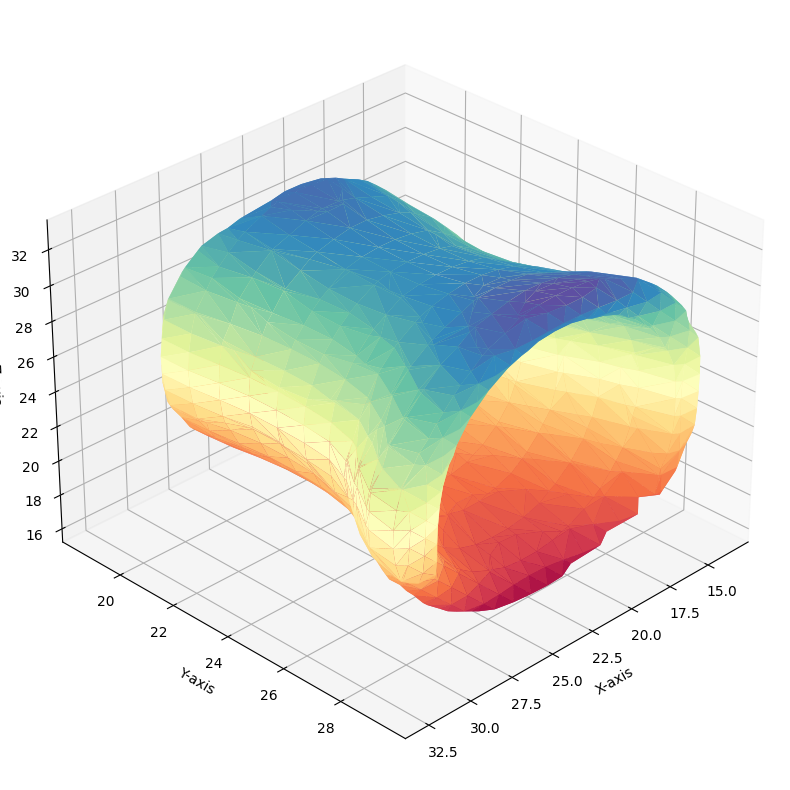

In [36]:
%matplotlib inline
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 使用 Marching Cubes 算法提取等值面
verts, faces, normals, values = measure.marching_cubes(data, level=0.01)

# 创建一个新的图形
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制等值面
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='Spectral', lw=1)

# 设置图形的视角和轴标签
ax.view_init(30, 45)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()


## visualize the latent code

In [38]:
bs=149
noise_x = torch.randn([bs, latent_dim, 3], device=device)
noise_s = torch.randn([bs, latent_dim], device=device)
fakes_x, fakes_s = sample(diffusion_model, noise_x, noise_s, steps, eta)

query_start = 0
query_end = 150
pred_so3_feat = fakes_x[query_start:query_end,:, :].to(device)
pred_inv_feat = fakes_s[query_start:query_end,:].to(device)
pred_scale = torch.ones((query_end-query_start)) + 0.2
pred_center = torch.zeros(query_end-query_start, 1, 3)

print(pred_so3_feat.shape, pred_inv_feat.shape, pred_scale.shape, pred_center.shape)
pred_so3_feat = torch.tensor(pred_so3_feat).float().to(device)
pred_inv_feat = torch.tensor(pred_inv_feat).float().to(device)
pred_scale = torch.tensor(pred_scale).float().to(device)
pred_center = torch.tensor(pred_center).float().to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([149, 256, 3]) torch.Size([149, 256]) torch.Size([150]) torch.Size([150, 1, 3])


/tmp/ipykernel_59451/3141179228.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_so3_feat = torch.tensor(pred_so3_feat).float().to(device)
/tmp/ipykernel_59451/3141179228.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_inv_feat = torch.tensor(pred_inv_feat).float().to(device)
/tmp/ipykernel_59451/3141179228.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_scale = torch.tensor(pred_scale).float().to(device)
/tmp/ipykernel_59451/3141179228.py:17: UserWarning: To copy construct from a tensor, it is recommended to 

In [39]:
codebook_path = "/home/ziran/se3/EFEM/cache/mugs.npz"

with np.load(codebook_path) as data:
    # 将 npz 文件内容转换为字典
    codebook = {key: data[key] for key in data}

del codebook['id']
for k, v in codebook.items():
    if isinstance(v, np.ndarray):
        newv = torch.from_numpy(v)
        codebook[k] = newv
    print(k, v.shape)

z_so3 (149, 256, 3)
z_inv (149, 256)
center (149, 1, 3)
scale (149,)
z_so3_proj (149, 256, 3)
z_so3_basis (149, 3, 3)
z_so3_var (149, 3)
bbox (149, 3)
bbox_c (149, 3)
pcl (149, 5000, 3)
cls (149,)


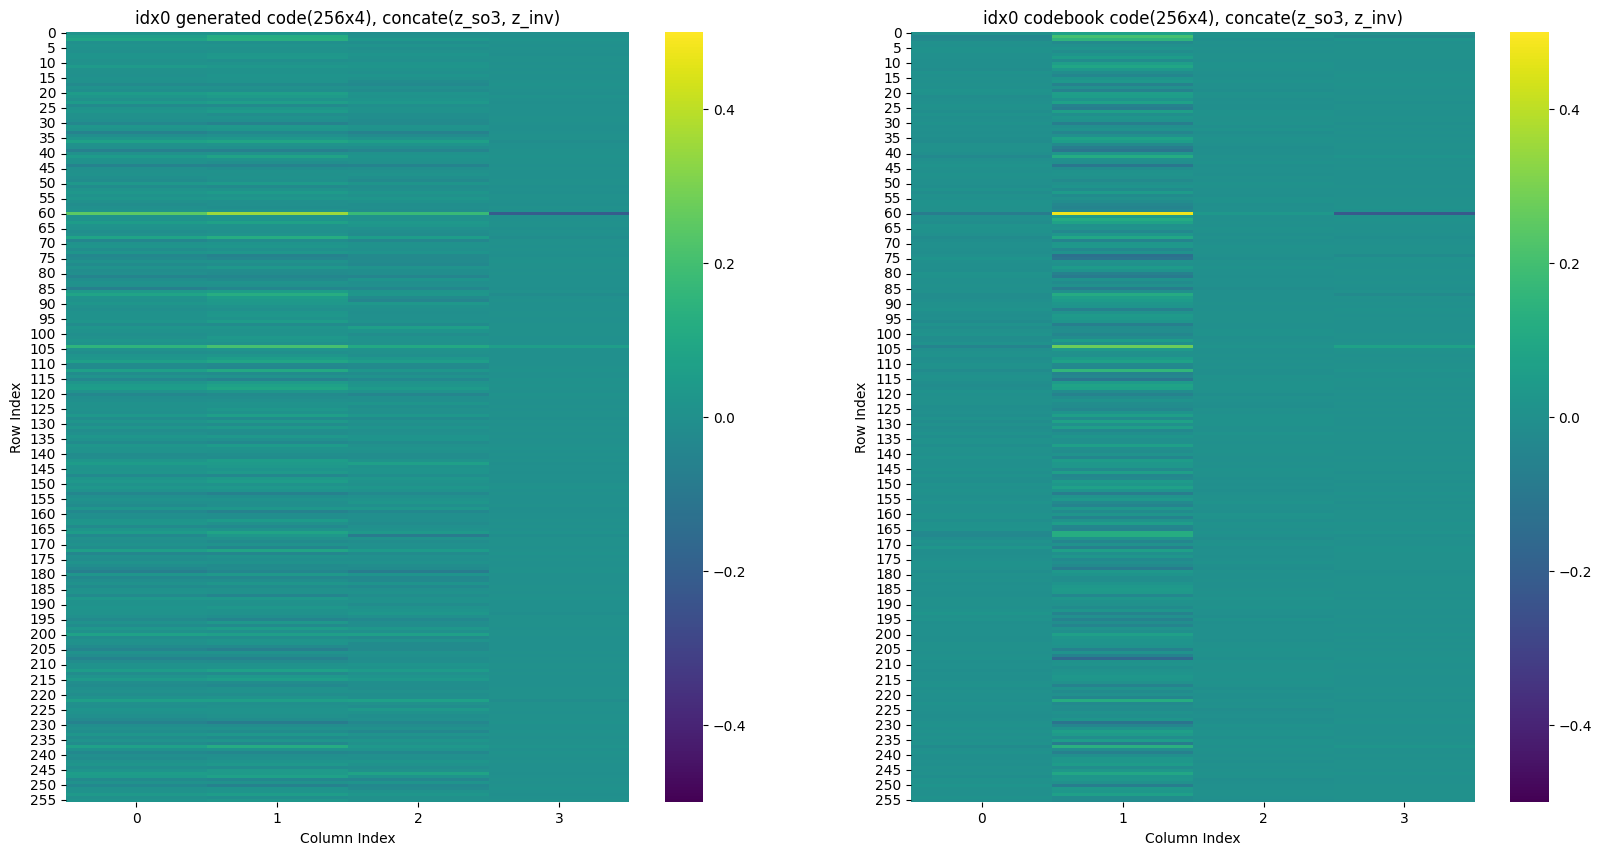

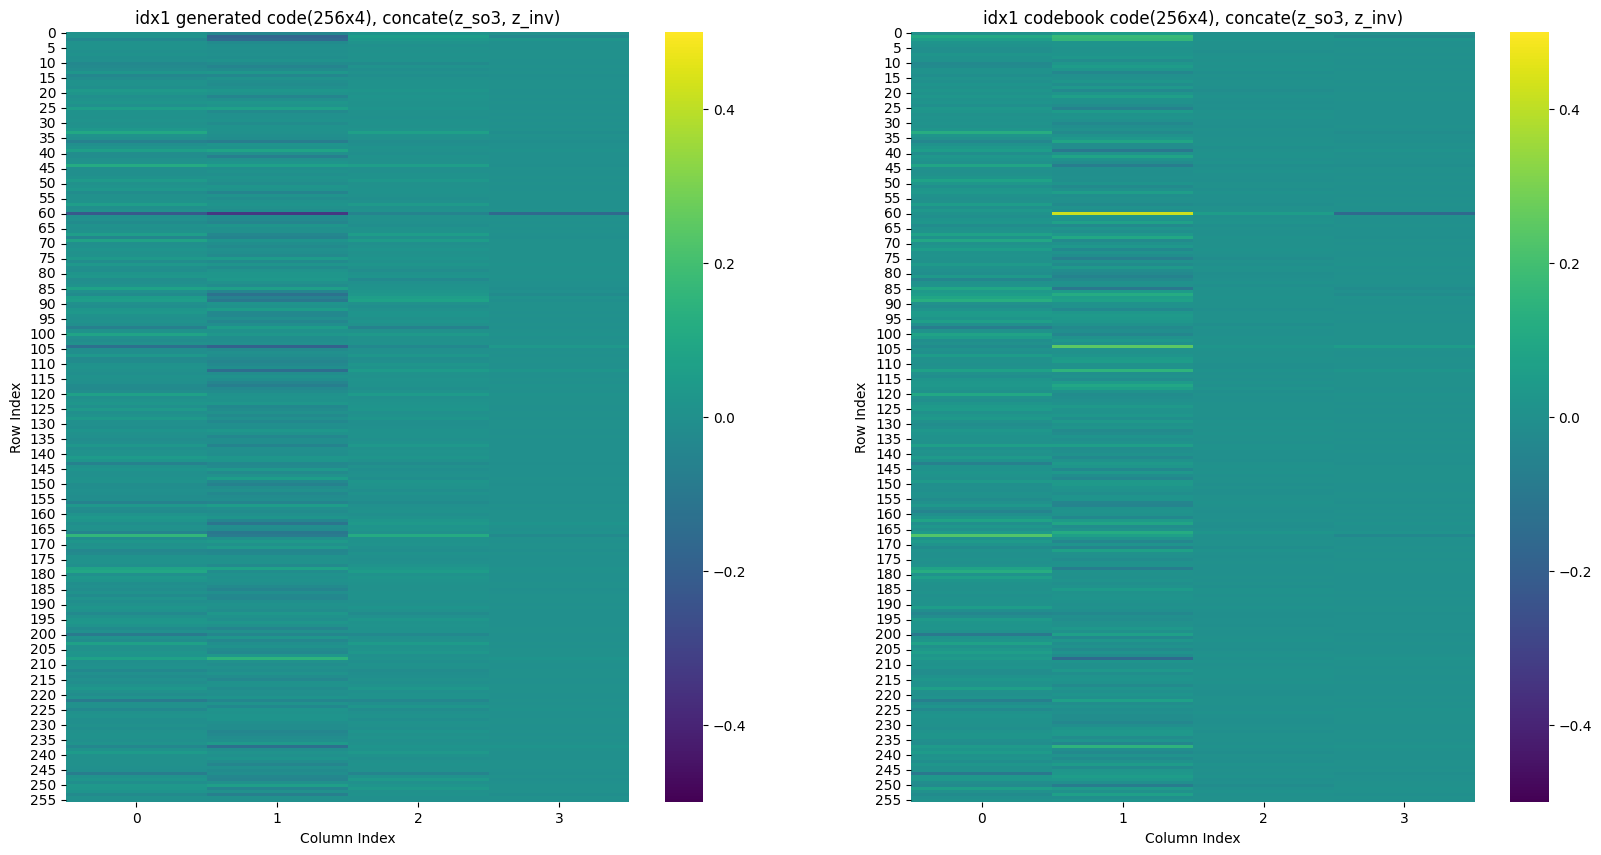

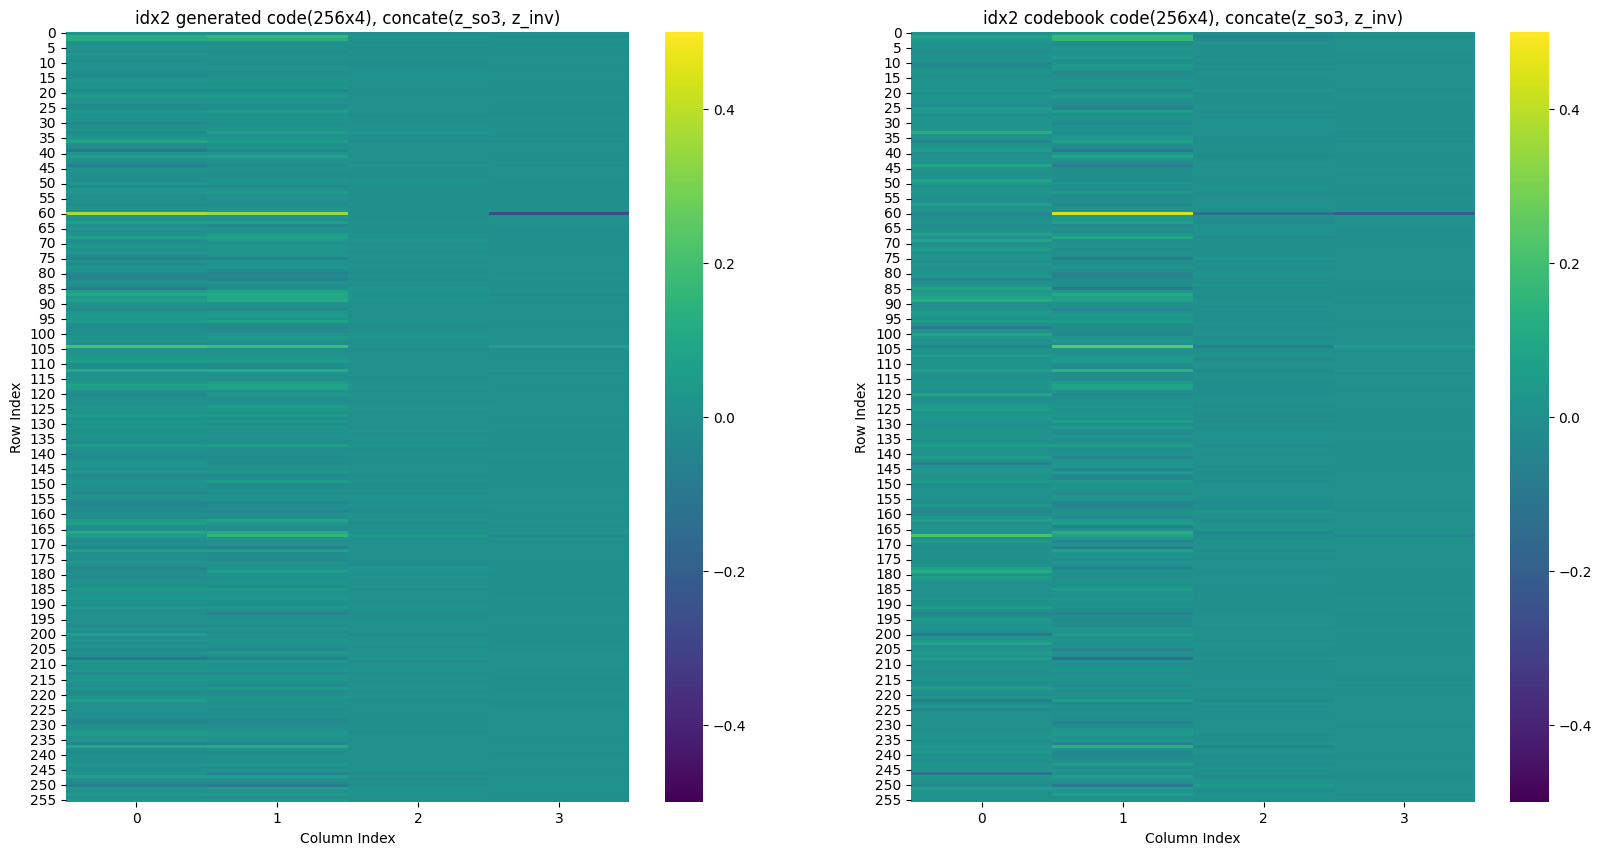

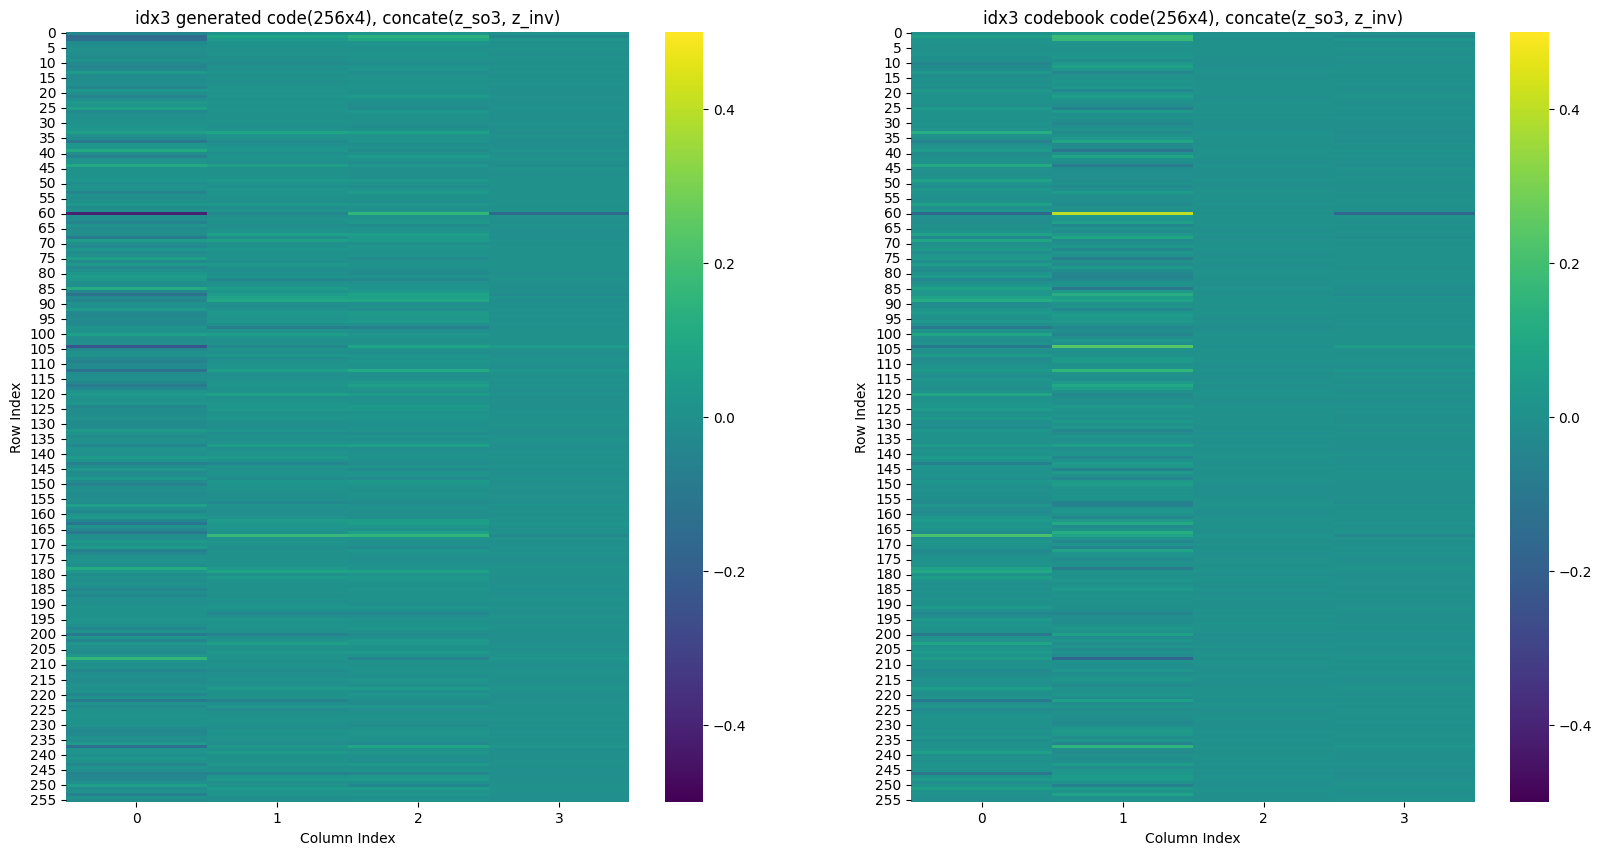

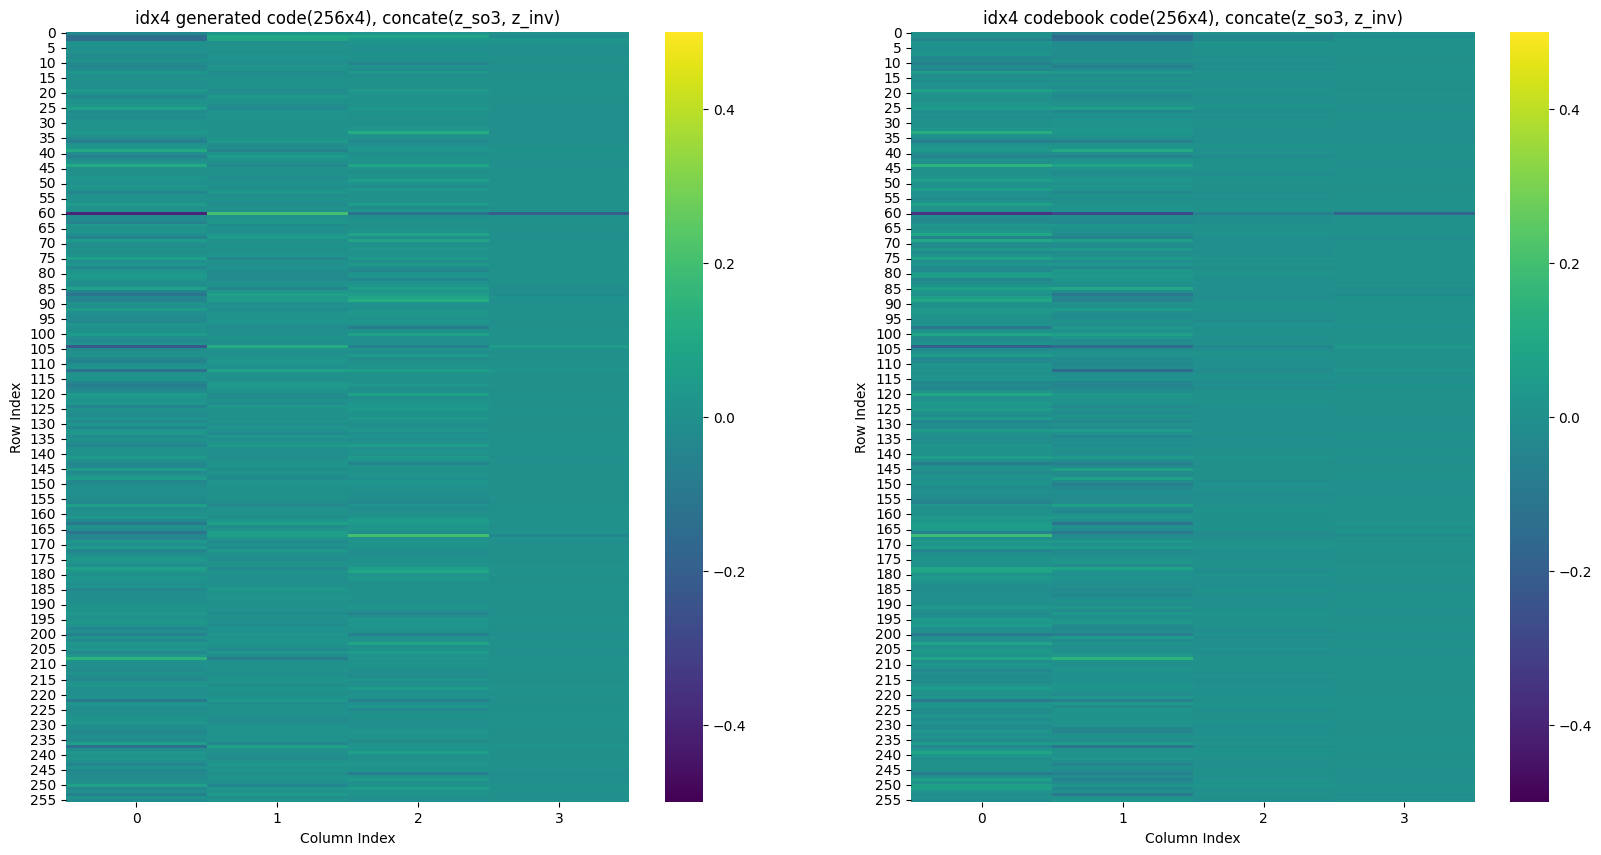

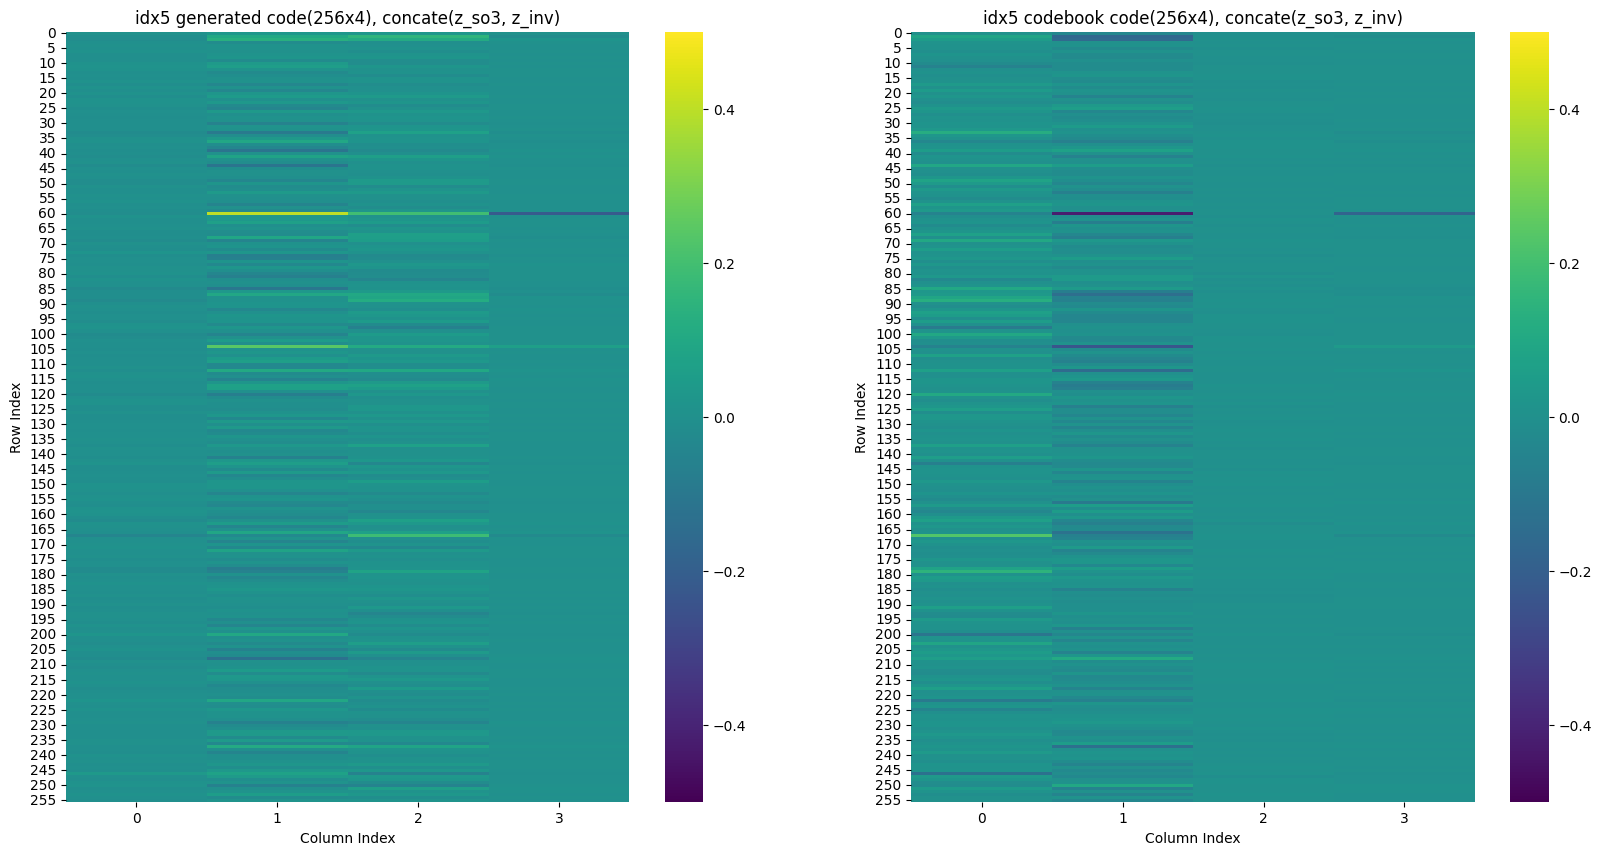

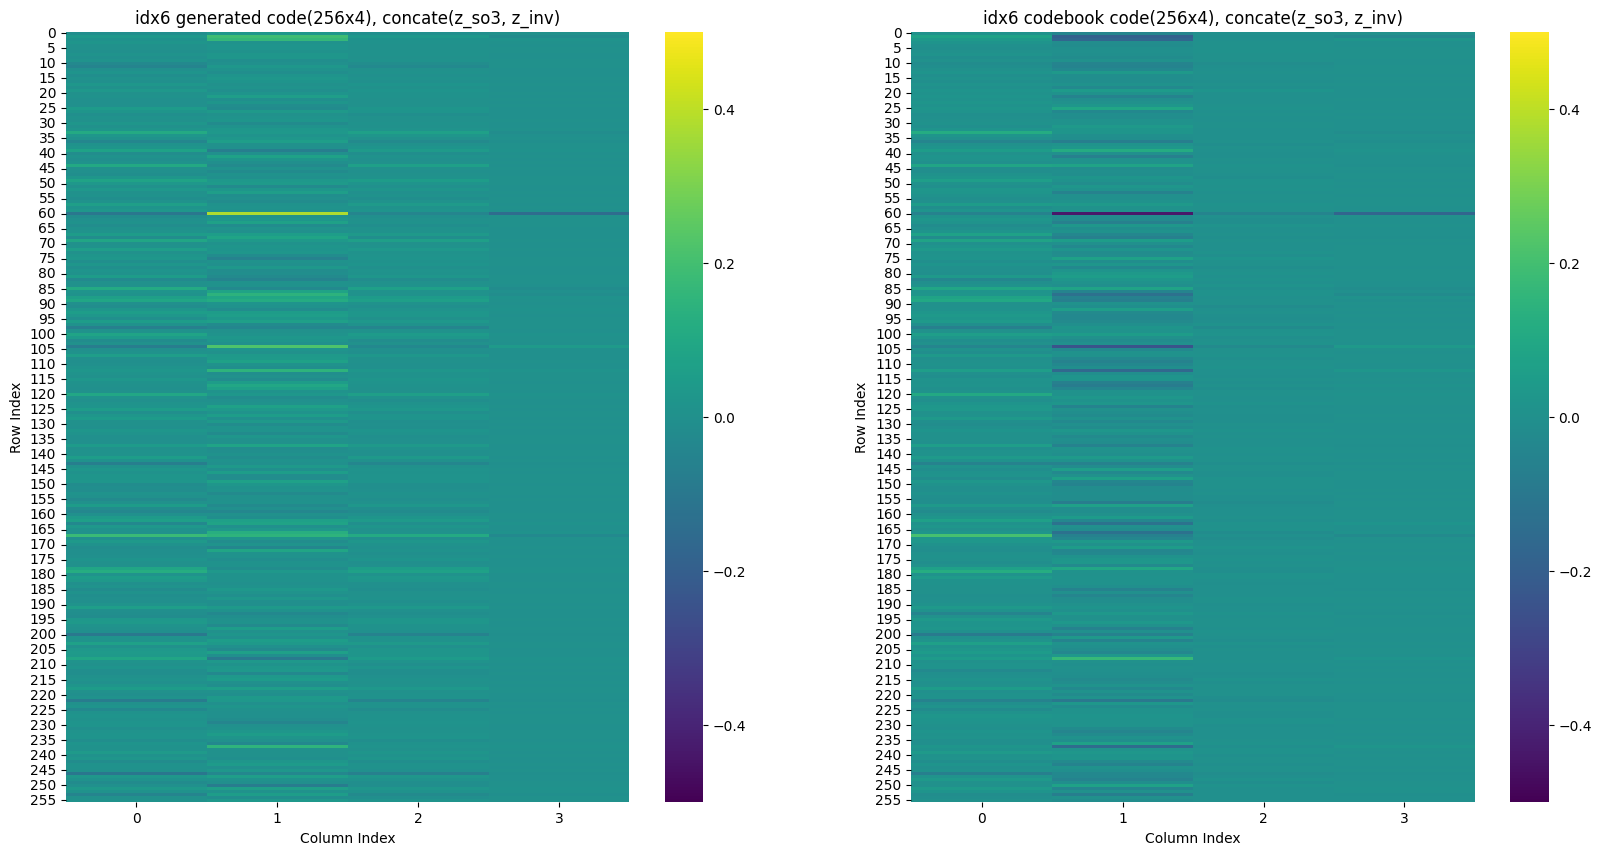

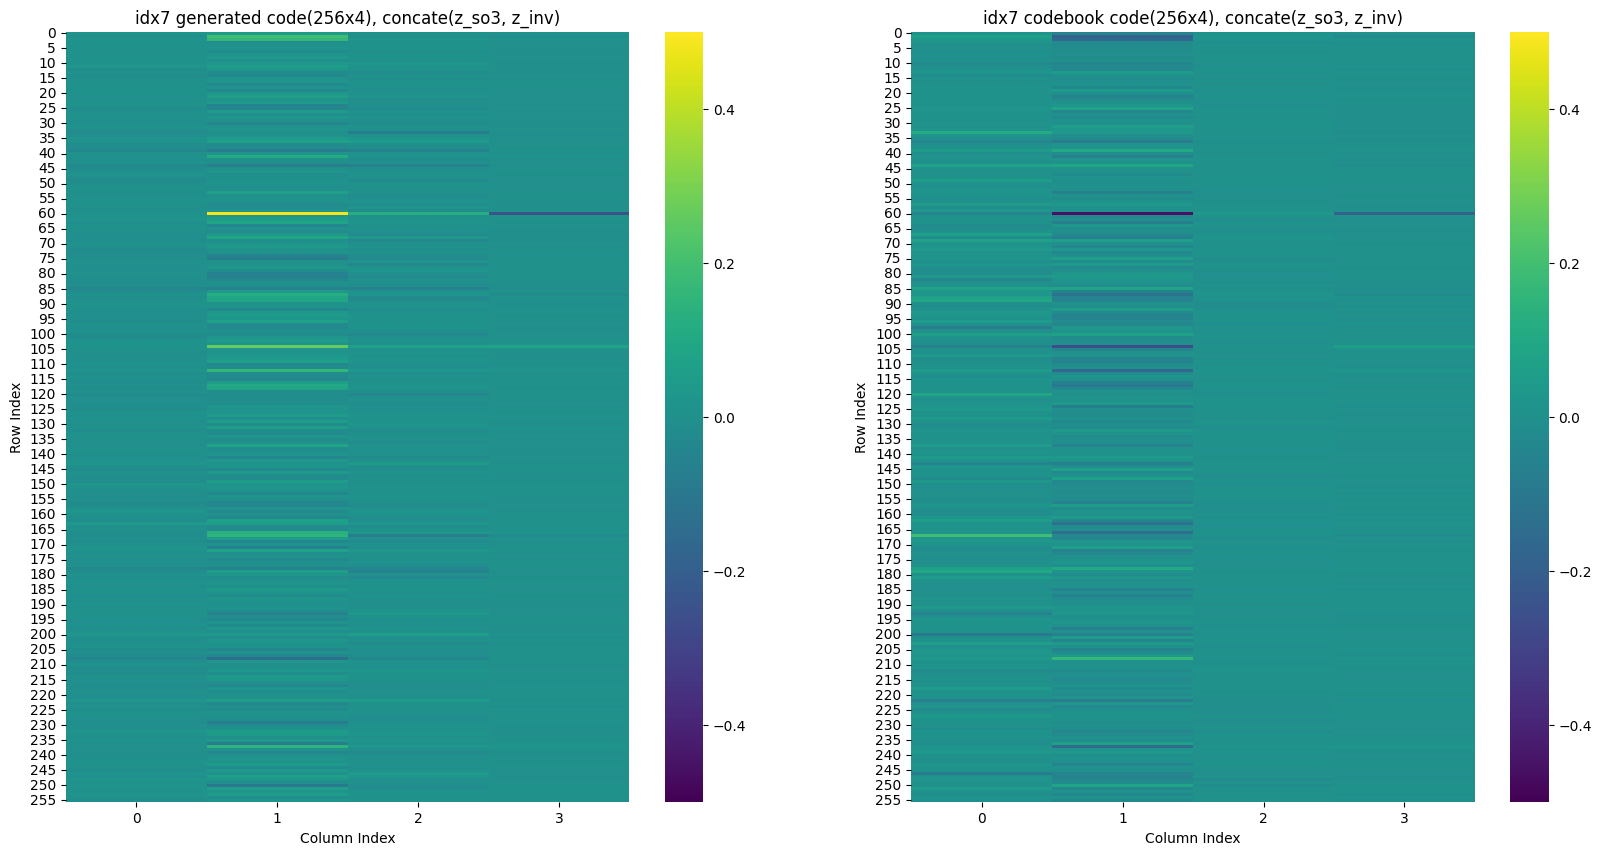

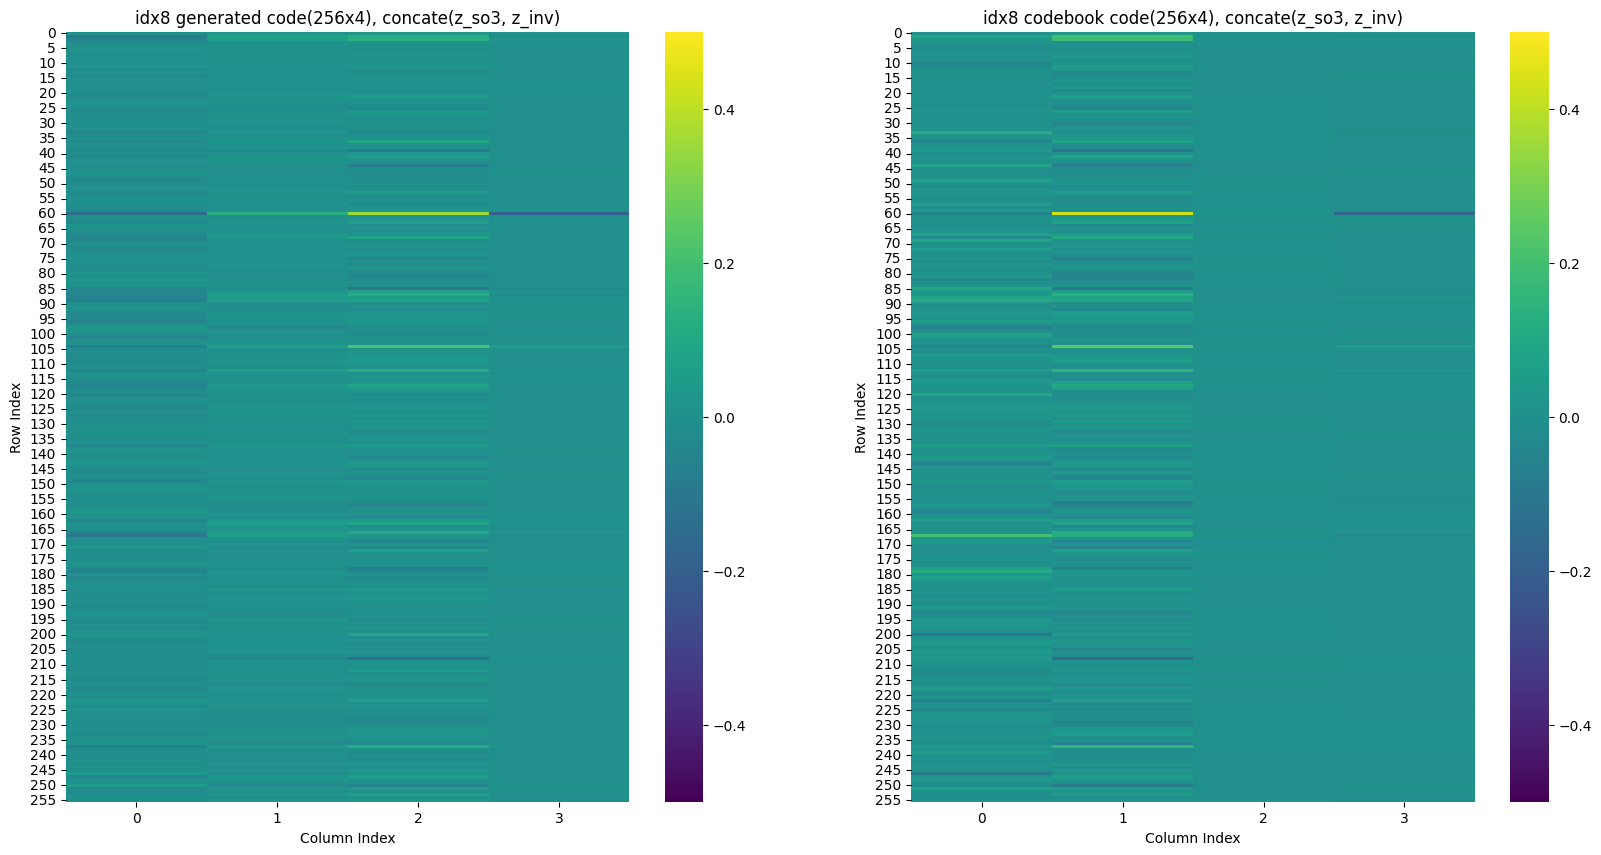

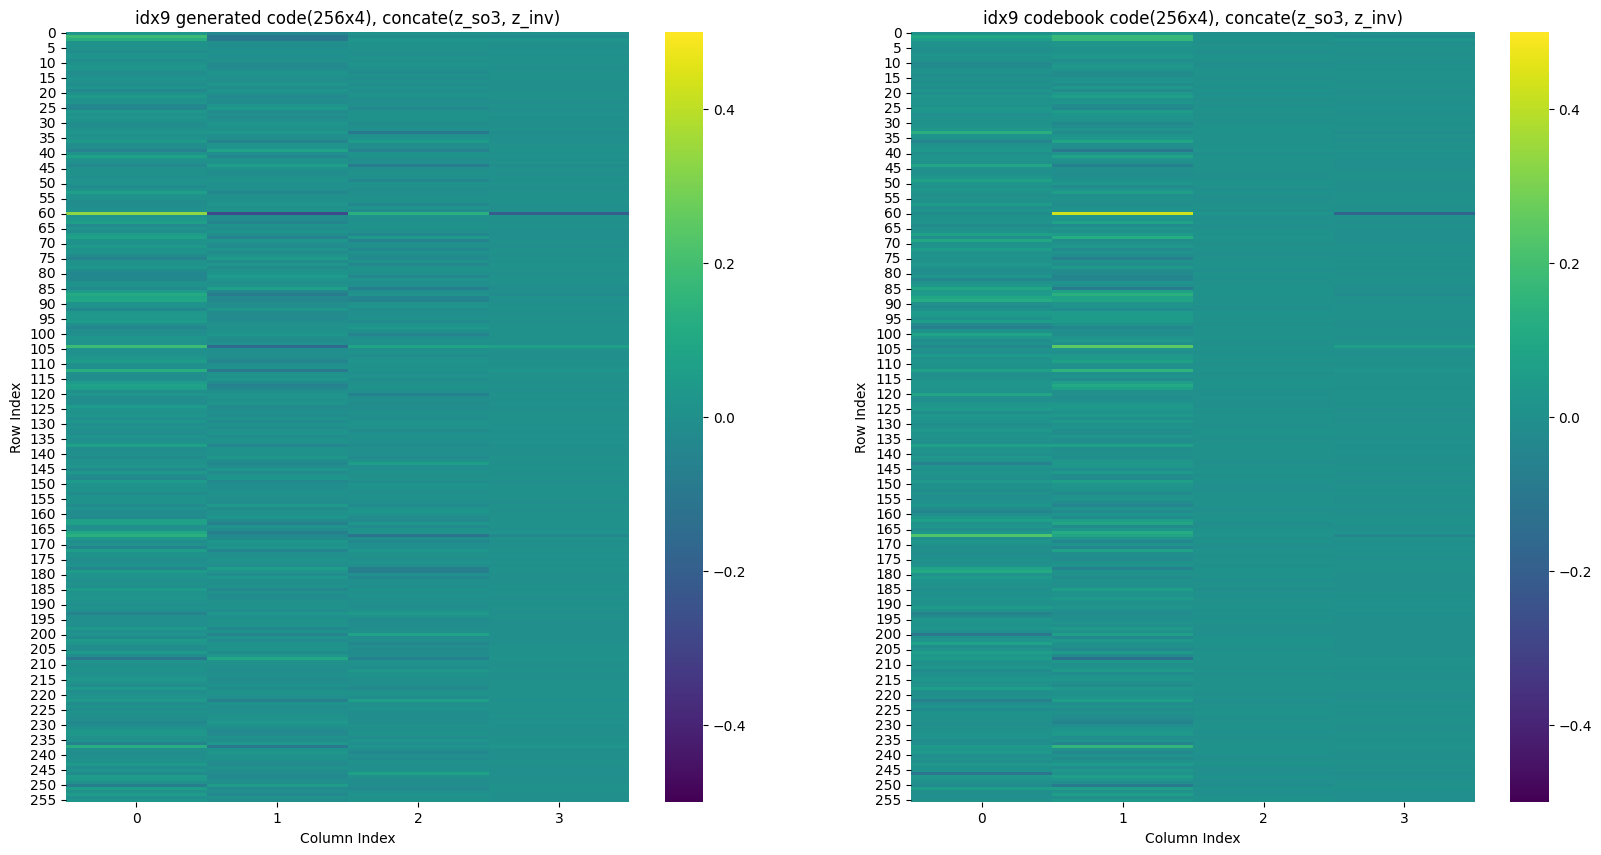

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


idx = 11
for idx in range(10):
    latentcode_generate = torch.concat([pred_so3_feat[idx], pred_inv_feat[idx].unsqueeze(1)], dim=1).cpu().numpy()


    codebook_pred_so3_feat = codebook['z_so3'][idx]
    codebook_pred_inv_feat = codebook['z_inv'][idx]
    # codebook_pred_scale = codebook['scale'][idx]
    # codebook_pred_scale = torch.ones_like(codebook_pred_scale) + 0.2
    # codebook_pred_center = codebook['center'][idx]
    # codebook_pred_center = torch.zeros_like(codebook_pred_center)

    latentcode_codebook = torch.concat([codebook_pred_so3_feat, codebook_pred_inv_feat.unsqueeze(1)], dim=1).cpu().numpy()





    # Visualizing both tensors using a heatmap with the same colormap
    plt.figure(figsize=(20, 10))

    # Heatmap for the first tensor
    plt.subplot(1, 2, 1)
    sns.heatmap(latentcode_generate, cmap='viridis', vmin=-0.5, vmax=0.5)
    plt.title(f'idx{idx} generated code(256x4), concate(z_so3, z_inv)')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')

    # Heatmap for the second tensor
    plt.subplot(1, 2, 2)
    sns.heatmap(latentcode_codebook, cmap='viridis', vmin=-0.5, vmax=0.5)
    plt.title(f'idx{idx} codebook code(256x4), concate(z_so3, z_inv)')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')

    plt.show()
    